In [24]:
import argparse
import pickle
import matplotlib.pyplot as plt

import numpy as np
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    burn_model,
    create_lorenz_model_observation,
)

from DA_PoC.common.observation_operator import (
    IdentityObservationOperator,
)

from omegaconf import OmegaConf
from tqdm.rich import tqdm


def generate_datapoint(x_current, lorenz, time_window):
    n = lorenz.state_dimension
    history = lorenz.lorenz_model.integrate(0, x_current, time_window)
    tlm = lorenz.lorenz_model.construct_tlm_matrix(0, x_current, time_window)
    tlm = tlm.reshape(-1, n)
    return (x_current, history[1], tlm), (history[1][:, -1])





# def generate_datapoint_GNmatrix(x_current, lorenz, time_window):
#     n = lorenz.state_dimension
#     history = lorenz.lorenz_model.integrate(0, x_current, time_window)
#     return (x_current, history[1], tlm), (history[1][:, -1])


def generate_dataset(lorenz, x0, assimilation_window, nsamples):
    train = []
    x = x0
    for _ in tqdm.trange(nsamples):
        datapoint, x = generate_datapoint(
            x_current=x, lorenz=lorenz, nobs=assimilation_window
        )
        train.append(datapoint)
    return train


In [25]:
assimilation_window = [0.05, 0.4, 0.6, 0.8]  # 6 hours, 48 hours, 72 hours, 96 hours
def get_lorenz_model(dim):
    lorenz = LorenzWrapper(dim)
    F = 8
    sigma_b_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
    charac_length = 1.5
    background_correlation = lambda x, y: np.exp(-((x - y) ** 2) / charac_length**2)
    x, y = np.meshgrid(np.arange(dim), np.arange(dim))

    B = sigma_b_sq * background_correlation(x, y)
    B_half = np.linalg.cholesky(B)
    B_inv = np.linalg.inv(B)

    sigma_obs_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
    R = sigma_obs_sq * np.eye(dim)
    R_half = np.linalg.cholesky(R)

    lorenz.background_error_cov_inv = B_inv
    lorenz.background = np.zeros(dim)

    lorenz.create_and_burn_truth()
    return lorenz

In [26]:
n = 100
lolo = get_lorenz_model(n)

In [27]:
assimilation_window_timesteps = [
    int(window / lolo.lorenz_model.dt) for window in assimilation_window
]
print(assimilation_window_timesteps)
window = assimilation_window_timesteps[-1]
lolo.H = lambda x: x
lolo.set_observations(nobs=window)
m = n * (window + 1)
identity_obs_operator = IdentityObservationOperator(m)

identity_obs_operator = IdentityObservationOperator(m)
num_model = create_lorenz_model_observation(
    lolo, identity_obs_operator, test_consistency=False
)


[2, 20, 30, 40]
Observation operator set already
lorenz.cost_function(x0_t)=36990.88278968313
numerical_model_lorenz.cost_function(x0_t)=36990.88278968313


In [28]:
dim = 100
F = 8
sigma_b_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
charac_length = 2
background_correlation = lambda x, y: np.exp(-((x - y ) ** 2) / charac_length**2)
x, y = np.meshgrid(np.arange(dim), np.arange(dim))

B = sigma_b_sq * background_correlation(x, y)
B_half = np.linalg.cholesky(B)
B_inv = np.linalg.inv(B)

sigma_obs_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
R = sigma_obs_sq * np.eye(dim)
R_half = np.linalg.cholesky(R)

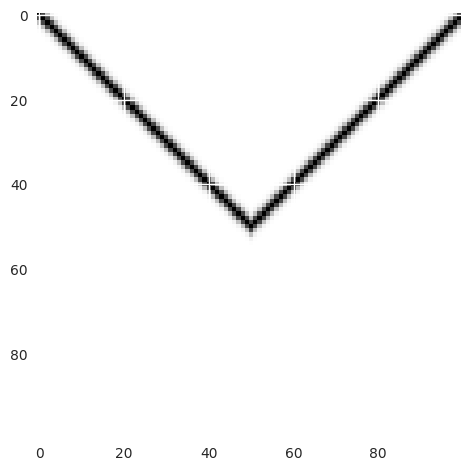

In [29]:
background_correlation = lambda x, y: np.exp((-(np.fmin(x - y, dim - x - y))** 2) / charac_length**2)
x, y = np.meshgrid(np.arange(dim), np.arange(dim))
plt.imshow(background_correlation(x, y))

In [30]:
b = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        # b[i, j] = np.exp(-0.5 * ())
        pass

In [31]:
num_model.obs_operator.H.shape

(4100, 4100)

In [32]:
num_model.tangent_linear(np.random.uniform(size=(n))).shape

(4100, 100)

In [33]:
(num_model.obs_operator.H @ num_model.tangent_linear(np.random.uniform(size=(n))).matmat(np.eye(n))).shape

(4100, 100)

In [34]:
tlm = num_model.tangent_linear(np.random.uniform(size=(n)))

SyntaxError: invalid syntax (4170918589.py, line 1)

In [ ]:
HG = num_model.obs_operator.H @ tlm.matmat(np.eye(n))
HG.shape

(HG.reshape(n,  window + 1, n)[:, 0, :]).shape
print(window)
idx_observed = [0, 10, 19]
obs_H = np.zeros((len(idx_observed), window + 1))
for i, idx in enumerate(idx_observed):
    obs_H[i, idx] = 1.0
obs_H.shape
plt.imshow(obs_H)


40


(3, 41)

In [ ]:
print((HG.reshape(n,  window + 1, n)[:, :, :]).shape)
AA = obs_H.reshape(1, len(idx_observed), window + 1) @ (HG.reshape(n,  window + 1, n)[:, :, :])
print(AA.shape)

(100, 41, 100)
(100, 3, 100)


In [ ]:
idx_observed_states = [3, 6, 10, 12]
idx_observed_timesteps = [0, 10, 19]
obs_state = np.zeros((len(idx_observed_states), n))
for i, idx in enumerate(idx_observed_states):
    obs_state[i, idx] = 1.0

obs_steps = np.zeros((len(idx_observed_timesteps), (window + 1)))
for i, idx in enumerate(idx_observed_timesteps):
    obs_steps[i, idx] = 1.0
print(f"{obs_state=}")
print(f"{obs_state @ np.arange(n)=}")
print(f"{obs_steps=}")
print(f"{obs_steps @ np.arange(1 + window)=}")
obs_H = np.kron(obs_state, obs_steps)
print(f"{obs_H.shape=}")
# (obs_H @ HG).shape

obs_state=array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
    

In [ ]:
i_x = 0
i_t = 2

print(HG.reshape(n,  window + 1, n)[idx_observed_states[i_x], idx_observed_timesteps[i_t], :])
print((obs_H @ HG)[i_x * len(idx_observed_states) + i_t - i_x])


[ 1.48971514e-01 -4.00942546e-01 -3.16546274e-01  5.06686317e-01
  4.39556702e-01  1.45034941e-01  4.26673420e-02  5.08926572e-03
  4.59893422e-04  8.45948274e-05  5.66546820e-06  8.01973159e-07
  6.26339435e-08  5.81117340e-09  4.91157248e-10  1.65712979e-11
  1.13991619e-12  3.85133676e-14  1.87889098e-15  1.10956231e-16
  5.66740414e-18  2.29522569e-19  6.89804489e-21  2.09928692e-22
  8.34164346e-24  2.02483172e-25  4.23516769e-27  7.39313083e-29
  1.46038168e-30  1.88898687e-32  6.30950950e-34  1.80239082e-35
  4.88062296e-37  9.07318531e-39  5.82794925e-41  2.21994974e-42
  7.33271469e-44 -3.94989851e-44 -1.07633293e-44  1.82406902e-42
 -2.72388871e-42 -1.55050813e-40  1.65526141e-40  6.40321539e-39
 -2.29462085e-39 -1.76203698e-37  1.34899415e-37  1.62389593e-35
 -3.68897867e-36 -4.71300328e-34 -1.76768419e-34  1.25170979e-32
  5.82545398e-33 -9.21795322e-31 -3.36104509e-31  2.53477579e-29
  7.81836765e-30 -6.36371641e-28  6.63367955e-28  3.72490349e-26
 -6.07500181e-26 -1.81286

In [ ]:
(obs_H @ HG).shape

(12, 100)

In [ ]:
AA[:, 1, :] - (HG.reshape(n,  window + 1, n)[:, 10, :])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num_model.forward(np.random.normal(size=n)).reshape(window + 1, n).T)

ValueError: dimension mismatch

In [ ]:
num_model.forward(np.random.normal(size=n).reshape(1, n))

ValueError: could not broadcast input array from shape (100,) into shape (1,)

In [ ]:
lolo.set_observations(nobs=20*window)

In [ ]:
YY = np.arange(12).reshape(4, 3)

In [ ]:
YY.reshape(12)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

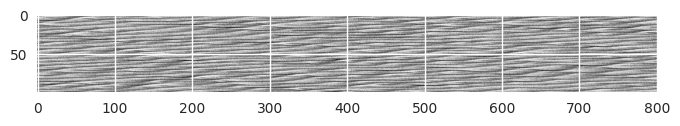

In [ ]:
plt.imshow(lolo.obs.reshape(n, 20*window + 1))

In [ ]:
obs = lolo.obs.reshape(n, 20*window + 1)
obs.shape

(100, 801)

In [ ]:
num_model..nobs = 100 * 40
state = num_model.forward_no_obs(np.random.uniform(size=(n))).reshape(n, (num_model.nobs + 1))
plt.imshow(state)

AttributeError: 'NumericalModel' object has no attribute 'lorenz'

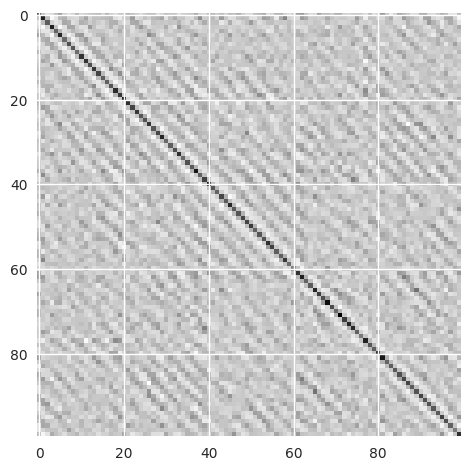

In [ ]:
plt.imshow(np.cov(state))